In [1]:
import sys
import os
import numpy as np
import napari
%matplotlib inline
from matplotlib import pyplot as plt  # graphic library, for plots
import numba as nb
import tifffile
import skimage

In [2]:
import filedialogs

In [3]:
from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io import EventsIterator
from metavision_sdk_cv import ActivityNoiseFilterAlgorithm

### Loading Datasets

In [4]:
path = filedialogs.gui_fname('example_data/')
path = path.decode('ascii')
print(path)

In [6]:
path

'C:/Users/B0067-WS-2/Documents/metavision/recordings/zebrafish_bouts/multiple_fish/good/recording_2023-06-16_16-24-27.raw'

In [9]:
path = 'C:/Users/B0067-WS-2/Documents/metavision/recordings/zebrafish_bouts/multiple_fish/good/recording_2023-06-16_16-24-27.raw'

In [10]:
record_raw = RawReader(path, max_events=100000000)
print(record_raw)

RawReader(C:/Users/B0067-WS-2/Documents/metavision/recordings/zebrafish_bouts/multiple_fish/good/recording_2023-06-16_16-24-27.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 100000000


In [11]:
events = record_raw.load_n_events(90000000)
print('Start Time:  ', events['t'][0]/1000, ' ms')
print('End Time:    ', events['t'][-1]/1000, ' ms')
print('Total Events:', len(events))

Start Time:   6.353  ms
End Time:     36534.185  ms
Total Events: 2286230


### Noise filtering
For whatever reason: If `filtered_events_` and `filtered_events` are the same variable, the export doesn't work

In [ ]:
'''
print('Started with: ', len(events),' events' )
noisereductionfilter = ActivityNoiseFilterAlgorithm(1280,720,1000)
filtered_events_ = noisereductionfilter.get_empty_output_buffer()
noisereductionfilter.process_events(events, filtered_events_)
filtered_events = filtered_events_.numpy()
print('After filtering: ', len(filtered_events),' events' )
'''

In [7]:
filtered_events = events

### Quick visualization

In [12]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

In [13]:
len(events)

2286230

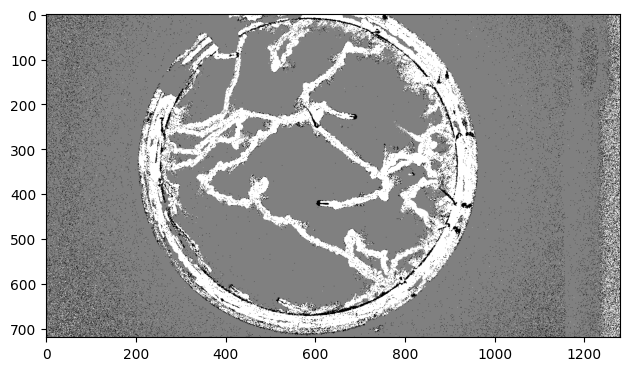

In [15]:
height, width = record_raw.get_size()
im = viz_events(events, height, width)
plt.imshow(im)
plt.tight_layout()

### Conversion to image-like array
* 8bit, Z or T, X, Y, C 
* e.g. np.random.randint(0, 255, (100, 720, 1280, 3), 'uint8')

In [16]:
@nb.njit
def events_to_stack(events, dt=1000, imagesize=(720, 1280)):
    height, width = imagesize
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    
    timepoints = int(np.ceil((max_timepoint - min_timepoint)/dt))    
    
    # generate a numpy array with the width 
    eventstack = np.zeros((timepoints,height,width,2), dtype='uint8')
    
    for event in events:
        x_pos = event[1]
        y_pos = event[0]
        timepoint = np.floor_divide((event[3]-min_timepoint),dt)
        if event[2] == 0:
            if eventstack[timepoint, x_pos, y_pos, 0] < 255:
                eventstack[timepoint, x_pos, y_pos, 0] += 1
        else: 
            if eventstack[timepoint, x_pos, y_pos, 1] < 255:
                eventstack[timepoint, x_pos, y_pos, 1] += 1
             
    
    return eventstack 

In [41]:
eventstack = events_to_stack(events, dt=50000)
print('Size of the eventstack in GB: ', eventstack.size/8/1024/1024/1024)

Size of the eventstack in GB:  0.15685558319091797


In [33]:
eventstack.shape

(366, 720, 1280, 2)

In [42]:
eventstack_crop = eventstack[:,:,200:975,:]

In [39]:
print('Size of the cropped eventstack in GB: ', eventstack_crop.size/8/1024/1024/1024)

Size of the cropped eventstack in GB:  0.09497115388512611


In [23]:
5000/5

1000.0

### Napari visualization

In [26]:
viewer = napari.Viewer()

In [44]:
my_new_layer = viewer.add_image(eventstack_crop, channel_axis=3, contrast_limits=[[0,5],[0,5]], name=['ON Events', 'Off Events'])

Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████| 2401/2401 [04:00<00:00,  9.97it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████| 2001/2001 [03:29<00:00,  9.57it/s]
C:\Users\B0067-WS-2\.conda\envs\eventcam1\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\B0067-WS-2\.conda\envs\eventcam1\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped
C:\Users\B0067-WS-2\.conda\envs\eventcam1\lib\site-packages\napari\layers\base\base.py:1632: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped


### Bokeh scatterplot examples

In [46]:
from bokeh.plotting import figure, show

p = figure(width=400, height=400)

# add a circle renderer with a size, color, and alpha
p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)

# show the results
show(p)

In [47]:
import numpy as np

from bokeh.plotting import figure, show

N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = np.array([ [r, g, 150] for r, g in zip(50 + 2*x, 30 + 2*y) ], dtype="uint8")

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

p = figure(tools=TOOLS)

p.scatter(x, y, radius=radii,
          fill_color=colors, fill_alpha=0.6,
          line_color=None)

show(p)

### Refiltering events

### Exporting data

In [35]:
on_events = eventstack_crop[:,:,:,1]

In [36]:
off_events = eventstack_crop[:,:,:,0]

In [ ]:
on_events.size

In [37]:
tifffile.imwrite('pigmented_fish_on_events.tif', on_events, photometric='minisblack')
tifffile.imwrite('pigmented_fish_off_events.tif', off_events, photometric='minisblack')